In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

import  torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

# A multi-character level MLP Language Model
Now here we want to consider a wider range of character inputs to predict the next character!

Benjio et al 2003 (MLP LM) was proposed a LM for words, we use it for characters:

    1- bc of the exponentially growing number of states as we increase the number of input chunks of words & characters, (like for 2 characters we had 27 * 27, for 3 char it will be  27**3 and so on!!), we can't continue with the probabilistic approach anymore, but we scale the NN.

    2- we are going to embed each word or character to a latent vector (embedding).
    
    3- This is a cool idea and allow us for out-of distribution generalization:
    
        3.1- During test time, the network might encounter inputs that has never exactly seen during in the empirical dataset (out-of-empirical-distribution).

        3.2 but if we train the network to put similar words or characters embeddings close together, then for example if it has seen "A dog is running in a room", it will ba able to change the words or characters with same semantic or grammar rule, and say "A cat is running in a room" or "The cat is running in the room". Even though you have not seen them!

        3.3- we have look up table to map the 27 characters to its multi dimensional embedding index

In [2]:

words = open('names.txt', 'r').read().splitlines()

In [3]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [4]:
import itertools
def plot_heatmap(tensor, nrow=None, ncol=None, fig_size=(10,10)):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    for i, j in itertools.product(range(nrow), range(ncol)):
        # x:col, y:rows, the origin is top left corner, makes bottom <->top
        plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

## create the training set of (x,y)

1. we need a block_size or context input window, meaning how many characters do we take to predict the next one?

2. to predict the first character e.g: e in emma, we need 3 previous characters! we assume theses pairs of input-output:

    '...' ---> 'e'

    '..e' ---> 'm'

    '.em' ---> 'm'

    'emm' ---> 'a'

    'mma' ---> '.'

In [5]:
xs, ys = [], []

# context input window: how many characters do we take to predict the next one?
window_size = 4

for w in words[:5]:
    context_window = [0]*window_size
    for ch in f'{w}.':
        idx_y = s_to_i[ch]
        ys.append(idx_y)

        xs.append(context_window) # input : ch1
        # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

        # shift_to_left context window and append the idx_y
        context_window = context_window[1:] + [idx_y]
xs = torch.tensor(xs)
# ys = torch.Tensor(ys)
ys = torch.tensor(ys)
print(f'{xs = }')
# print(ys)
dataset_size = xs.shape[0]
print(f'{dataset_size = }')
print(f'{window_size = }')
nclass = 27
print(f'{nclass = }')

xs = tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        [ 5, 13, 13,  1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0, 15],
        [ 0,  0, 15, 12],
        [ 0, 15, 12,  9],
        [15, 12,  9, 22],
        [12,  9, 22,  9],
        [ 9, 22,  9,  1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  1],
        [ 0,  0,  1, 22],
        [ 0,  1, 22,  1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  9],
        [ 0,  0,  9, 19],
        [ 0,  9, 19,  1],
        [ 9, 19,  1,  2],
        [19,  1,  2,  5],
        [ 1,  2,  5, 12],
        [ 2,  5, 12, 12],
        [ 5, 12, 12,  1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0, 19],
        [ 0,  0, 19, 15],
        [ 0, 19, 15, 16],
        [19, 15, 16,  8],
        [15, 16,  8,  9],
        [16,  8,  9,  1]])
dataset_size = 32
window_size = 4
nclass = 27


## Emebeddings Look-up table
in the paper, they embed 17K words into 30 dimensional embedding vectors.

we have 27 characters, let's embed them into 2 dimensional embedding vectors.

we initialize them with a normal distro. and store them in a tensor as a look up table

we can treat it as a look up table

In [6]:
g = torch.Generator().manual_seed(2147483647)
# for each character, 
emb_lkt = torch.randn(nclass,2, generator=g)
print(emb_lkt)
emb_lkt[0] # embedding of '.'

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])


tensor([ 1.5674, -0.2373])

### play around with torch
to learn the syntax, common errors, and common practices:

In [7]:
s_to_i['.']

0

encodings input must be a tensor

In [8]:
F.one_hot(s_to_i['.'], num_classes = nclass)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
F.one_hot([s_to_i['.']], num_classes = nclass)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
F.one_hot(torch.tensor(s_to_i['.']), num_classes = nclass)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

remember: torch can not multiply 2 different type of tensors!! the output of one-hot is int (long)

In [ ]:
F.one_hot(torch.tensor(s_to_i['.']), num_classes = nclass) @ emb_lkt

RuntimeError: expected scalar type Long but found Float

If we **`multiply the one-hot encoding to the emb_lkt`** we get the corresponding **`embedding of the character`**.

this means we can **`treat embedding dimensions as the weights of the first layer with 2 Neurons (in:27, out:2) `** connected to the **`one-hot inputs`** (for each activated input, the emb_lkt that are weights pass to the output).

This means we can also train the emb_lkt !!

In [ ]:
F.one_hot(torch.tensor(s_to_i['.']), num_classes = nclass).float() @ emb_lkt

tensor([ 1.5674, -0.2373])

but we are going to use a simple indexing, like emb_lkt[0], for now, bc it's simply faster, no need for matrix multiplication

### get the embeddings of context window

As we had before, we can index a tensor with a list or another tensor 1d or 2d or ... in torch :)))

The shape of emb_lkt is : ncharacter, num embedding dimension

when we index with another nD tensor or list, torch treats each entry in that tensor or list as an index.

So the shape of output will be exactly the shape of the nD tensor or list, and replacing (map) each index with their embeddings

In [7]:
print(emb_lkt[s_to_i['.']])
print(emb_lkt[0]) # embedding of '.'
print(emb_lkt[0,1]) # the 2nd item of embedding of '.'
print(emb_lkt[[0,1]]) # embeddings of '.a'
print(emb_lkt[torch.tensor([0,0,0,1])]) # embeddings of '...a'
print(emb_lkt[torch.tensor( [[0,0,0,1], [0,0,1,2]] )]) # embeddings of '...a' & '..ab'


tensor([ 1.5674, -0.2373])
tensor([ 1.5674, -0.2373])
tensor(-0.2373)
tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008]])
tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.0274, -1.1008]])
tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.0274, -1.1008]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.0274, -1.1008],
         [ 0.2859, -0.0296]]])


So we can get the embedding of the whole data set!

In [10]:
emb_lkt[xs].shape # sample in batch, place in input window, embedding dim for each character

torch.Size([228146, 4, 2])

In [11]:
print(xs[13,2]) # 13th sample in batch , place in input window
print(emb_lkt[xs][13,2]) # the embedding of that

tensor(0)
tensor([ 1.5674, -0.2373])


In [8]:
emb = emb_lkt[xs]
emb_dim = emb.shape[-1]
emb.shape
# sample in batch, place in input window, embedding dim for each character

torch.Size([32, 4, 2])

## constructing the hidden layer
we have a n_place_in_window * embedding_dim input

In [9]:
hlayer_size = 100
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn( window_size*emb_dim, hlayer_size , generator=g)
b1 = torch.randn( hlayer_size, generator=g)
W1.shape

torch.Size([8, 100])

so the shape of emb & W1 does not allow us to multiply them!!

In [ ]:
emb @ W1 + b

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x2 and 8x100)

we need to flatten the input window (4*2) to 8 !!

There multiple ways to that:

1- the unefficient, memory intensive one:

torch.cat(tensors=, dim=)

In [ ]:
new_emb = torch.cat(tensors=[emb[:,w,:] for w in range(window_size)], dim=1) # dim=0 is for samples , dim=1 is for window_slots
new_emb.shape

torch.Size([32, 8])

In [ ]:
# use unbind instead of loop: give separate tensors of window slots
new_emb = torch.cat(tensors=torch.unbind(emb, dim=1), dim=1)
new_emb.shape

torch.Size([32, 8])

2. The best way is to use torch.view()

#### Tutorial on concatination in PyTorch

it's extremely efficient, here is a tutorial about torch

In [ ]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [ ]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

torch can also infer a dimension by assigning -1 :)))

In [ ]:
a.view(-1,3,3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

In [ ]:
a.view(2,3,3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

This is due to the way torch stores the values:

in each tensor, there is an underlying "storage()", which is a 1d "sequence", and this is how each tensor is represented in the computer memory.

When we call .view(2,3,3) we're manipulating some of the attributes of that tensor, that dictates to torch how this 1d vector sequence is interpreted to be an nD tensor

This is amazing bc when we call .view(), it's done without any memory operation (copy, paste, erase, move ).

Those attributes are offsets, strides and shapes, if you need. Search for PyTorch Internals

In [ ]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

#### Back to our embeddings

so basically you don't need to define another tensor for concatination!! just use .view() and -1 for indexing in operations :))

In [ ]:

emb.view(dataset_size, window_size*emb_dim) == new_emb

Now for @ we can do it easily.

let's check for the + and broadcasting!!:

In [ ]:
print(b1.shape)
(emb.view(dataset_size, -1)@W1).shape

torch.Size([100])


torch.Size([32, 100])

dataset_size | hlayer_size

nothing    | hlayer_size

Broadcasting will create a fake dimension in b and copy that dataset_size times. and the same bias will be added to all samples.

In [10]:
h = torch.tanh(emb.view(dataset_size, -1)@W1 + b1 )
h.shape

torch.Size([32, 100])

## the output layer


In [11]:
g = torch.Generator().manual_seed(2147483647)
W2 = torch.randn(hlayer_size, nclass, generator=g)
b2 = torch.randn(nclass, generator=g)

In [12]:
logits = h @ W2 + b2
counts = logits.exp()
counts.shape

torch.Size([32, 27])

In [13]:
# sum must be over counts of classes for one sample
# meaning dim 1 , broadcasting again
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([32, 27])

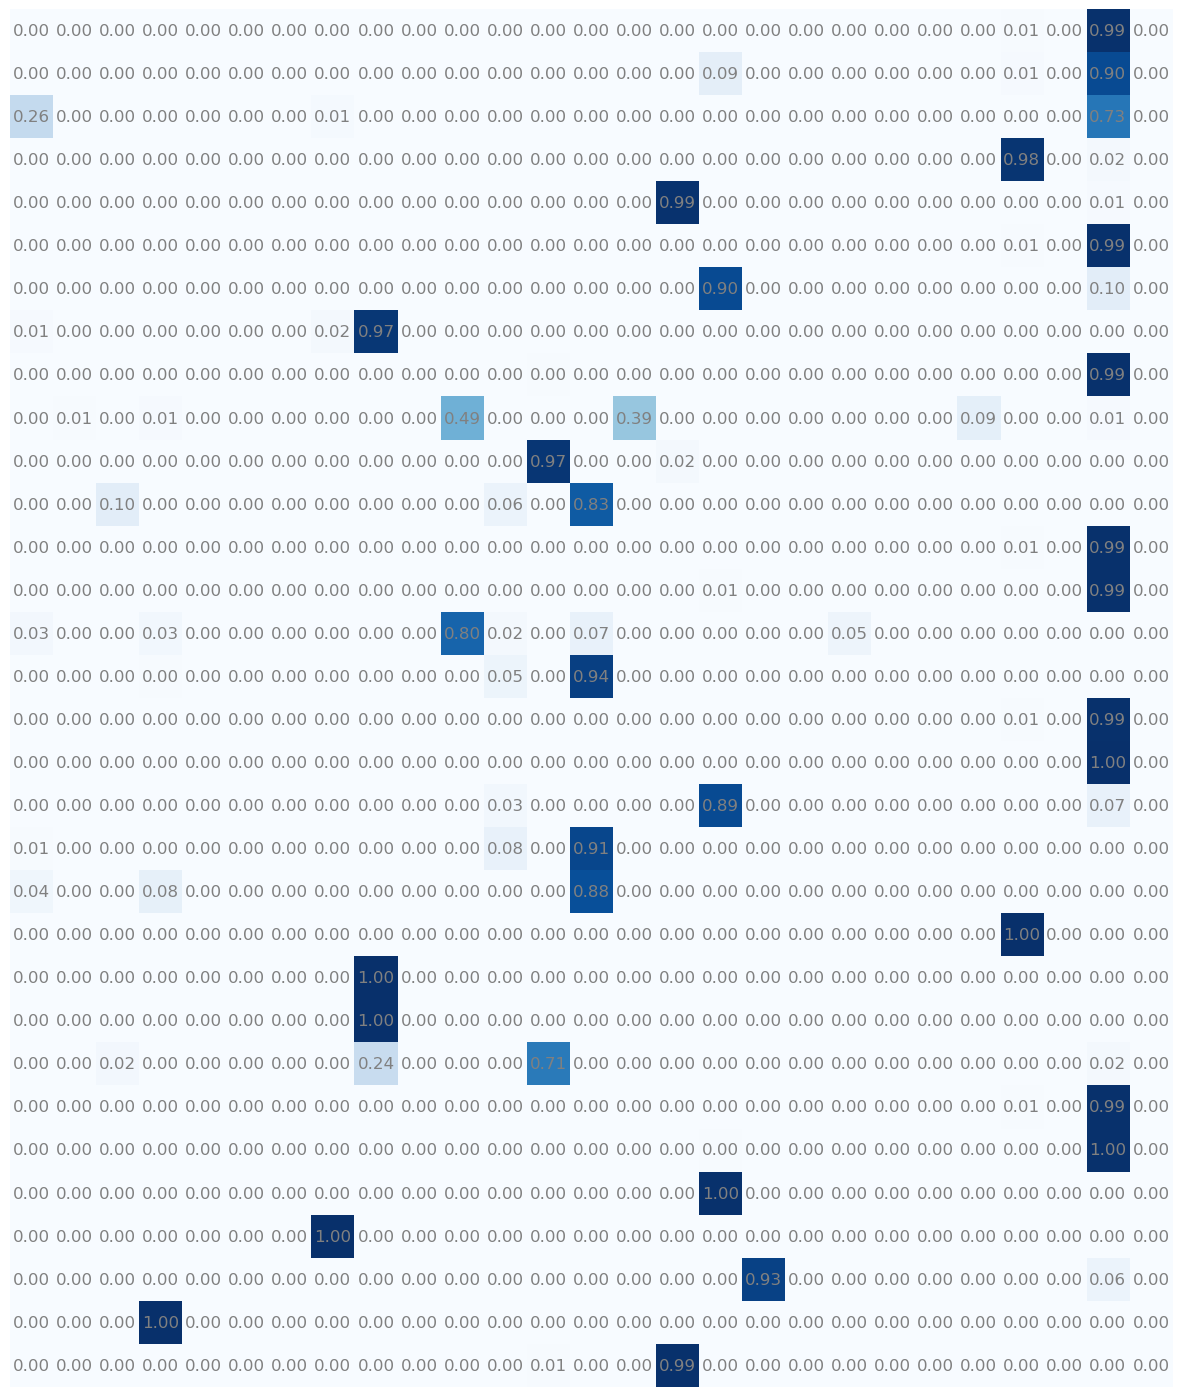

In [14]:
plot_heatmap(probs, fig_size=(15,30))

In [ ]:
# like we had before,
# I need to go row-by-row and get the ys col
probs[torch.arange(dataset_size), ys]

tensor(19.7731)

## The summary of parameters

In [194]:
g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( nclass, emb_dim, generator=g)
W1 = torch.randn( window_size*emb_dim, hlayer_size , generator=g)
b1 = torch.randn( hlayer_size, generator=g)
W2 = torch.randn( hlayer_size, nclass, generator=g)
b2 = torch.randn( nclass, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

3681

## The Whole loop with PyTorch Functional

#### PyTorch Loss-Input Confusion (Cheatsheet)

- `torch.nn.functional.binary_cross_entropy` takes (logistic sigmoid, ys) values as inputs
- `torch.nn.functional.binary_cross_entropy_with_logits` takes (logits, ys) as inputs 
- `torch.nn.functional.cross_entropy` takes (logits, ys) as inputs (performs `log_softmax` internally)
- `torch.nn.functional.nll_loss` is like `cross_entropy` but takes (log-probabilities or log-softmax , ys ) values as inputs

you must use these functionals,

they're more memory efficient, bc:

1- In Forward path, they don't implement intermediate operations separately like exp() then log(), then mean ,...

    They have fused kernels that very efficiently evaluate these expressions.

2- The backward path is mathematically simpler and faster, bc we can analytically derive a simpler equation, like we had in micrograd!! remember!!:

    e.g: the gradient for tanh is (1 - tanh**2) very simpler operation than using exp() and compute everything again

3- They are usually more numerically well behaved for extreme (noise) cases:

    e.g: if you get a very large positive number in the logits, the exp of that might run of range in our floating point number that represent the counts, extremely high  division by zero, ...)

    What PyTorch does then!?
        
        if you add an offset to the logits, bc of the normalization, you get the same probabilities (not counts!) afterward.
        
        so , torch basically, find the largest logit and subtract it, then compute the counts without any overflow!! and still giving the same probability.

In [ ]:
# example for 3:
logits = torch.tensor([-5, -3, 0, 100]) + 0 # * log counts
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [ ]:
logits = torch.tensor([-5, -3, 0, 100]) + -100 # * log counts
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

### batch optimization & SGD
like the permutation we had in micrograd

here we use torch.randint to get random int

we must index both xs & ys

In [166]:
batch_size = 8
torch.randint(low=0, high=dataset_size, size=(batch_size,))

tensor([190294,  91512, 225753, 142058, 217020, 201322,  91490,  26965])

### the loop

In [179]:
lr = 0.1
l2coef = 0.01
batch_size = dataset_size

for k in range(100):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=dataset_size, size=(batch_size,))
    emb = emb_lkt[xs[mini_batch_idx]] # batch_size, window_size, emb_dim
    h = torch.tanh(emb.view(batch_size, -1)@W1 + b1 ) # batch_size, hlayer_size
    logits = h @ W2 + b2 # * log counts [batch_size, nclass]
    # counts = logits.exp() # * equivalent to counts [b, nclass]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
     
    # loss = -probs[torch.arange(batch_size), ys].log().mean() + l2coef*(W**2).mean()

    loss = F.cross_entropy(logits, ys[mini_batch_idx])

    # for p in parameters:
    #     p.grad = None
    loss.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    print(f'iteration: {k} | loss: {loss.item()}')

iteration: 0 | loss: 2.928352117538452
iteration: 1 | loss: 2.6236789226531982
iteration: 2 | loss: 2.571687936782837
iteration: 3 | loss: 2.542731523513794
iteration: 4 | loss: 2.5214524269104004
iteration: 5 | loss: 2.5054826736450195
iteration: 6 | loss: 2.5027477741241455
iteration: 7 | loss: 2.4928383827209473
iteration: 8 | loss: 2.483626365661621
iteration: 9 | loss: 2.4799180030822754
iteration: 10 | loss: 2.478471279144287
iteration: 11 | loss: 2.4739043712615967
iteration: 12 | loss: 2.4694454669952393
iteration: 13 | loss: 2.4668385982513428
iteration: 14 | loss: 2.46107816696167
iteration: 15 | loss: 2.460569143295288
iteration: 16 | loss: 2.454664707183838
iteration: 17 | loss: 2.4541611671447754
iteration: 18 | loss: 2.450788736343384
iteration: 19 | loss: 2.4482078552246094
iteration: 20 | loss: 2.4487555027008057
iteration: 21 | loss: 2.4499707221984863
iteration: 22 | loss: 2.4439096450805664
iteration: 23 | loss: 2.444772720336914
iteration: 24 | loss: 2.4417302608489

### Learning rate Exploration
torch.linspace() gives us a 1d tensor of size steps evenly spaced from start to end 

plot the loss & lr to find the best lr

during exploration, start from low to high learning rates, bc they usually have low reduction in loss and allow larger ones to get to the party.

set batch_size not very low and not the whole dataset

In [183]:
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

In [195]:
lri = []
lossi = []
l2coef = 0.01
batch_size = 64

for k in range(1000):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=dataset_size, size=(batch_size,))
    emb = emb_lkt[xs[mini_batch_idx]] # batch_size, window_size, emb_dim
    h = torch.tanh(emb.view(batch_size, -1)@W1 + b1 ) # batch_size, hlayer_size
    logits = h @ W2 + b2 # * log counts [batch_size, nclass]
    # counts = logits.exp() # * equivalent to counts [b, nclass]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
     
    # loss = -probs[torch.arange(batch_size), ys].log().mean() + l2coef*(W**2).mean()

    loss = F.cross_entropy(logits, ys[mini_batch_idx])

    # for p in parameters:
    #     p.grad = None
    loss.backward()

    # update &
    lr = exponential_lr[k]
    lri.append(lr_expo[k]) # store the exponent
    lossi.append(loss.item())
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    print(f'iteration: {k} | loss: {loss.item()}')

iteration: 0 | loss: 18.790063858032227
iteration: 1 | loss: 18.748458862304688
iteration: 2 | loss: 19.22270965576172
iteration: 3 | loss: 16.048357009887695
iteration: 4 | loss: 18.345142364501953
iteration: 5 | loss: 16.60384750366211
iteration: 6 | loss: 17.547109603881836
iteration: 7 | loss: 19.46603775024414
iteration: 8 | loss: 19.79237937927246
iteration: 9 | loss: 19.57198715209961
iteration: 10 | loss: 18.106203079223633
iteration: 11 | loss: 16.734207153320312
iteration: 12 | loss: 18.6744441986084
iteration: 13 | loss: 18.30401611328125
iteration: 14 | loss: 18.825593948364258
iteration: 15 | loss: 17.513948440551758
iteration: 16 | loss: 16.597421646118164
iteration: 17 | loss: 18.806737899780273
iteration: 18 | loss: 16.960378646850586
iteration: 19 | loss: 18.583980560302734
iteration: 20 | loss: 18.16211700439453
iteration: 21 | loss: 16.314538955688477
iteration: 22 | loss: 17.639759063720703
iteration: 23 | loss: 20.58612823486328
iteration: 24 | loss: 19.01128768920

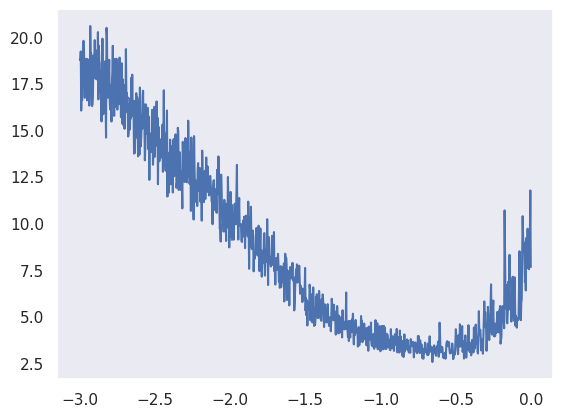

In [196]:
plt.plot(lri, lossi)

we can see the best exponent range is between -1.0 - -0.5 meaning the best range for lr itself is 0.1 - 0.3 :)

So we start with 0.1 for let say 10K batch, then when the loss plateau off, we start Learning rate decay, e.g. by a factor of 10, try 0.01 then 0.001 , ... 

## Let's Generate some samples like Bigram

In [95]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    idx = 0
    name = ''
    while True:
        # Forward path
        xenc0 = F.one_hot(torch.tensor([idx]), num_classes = 27).float()
        logits = xenc0 @ W # * log counts [b, nclass]
        counts = logits.exp() # * equivalent to counts [b, nclass]
        probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
        idx = torch.multinomial(probs.detach(), num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        ch = i_to_s[idx]
        # print(ch)
        name += ch
    print(name)

mor
axx
minaynnnyles
koneraisah
andhunizarie
pberen
iadeesh
h
jlligtien
egyrhm
